# Training Variational Quantum Models with Barren Plateaus Mitigation Strategies
*Training QNN treated with method 0 (General) of the BP mitigation strategy (Cancer)*

**Authors:**
- Jacob Cybulski and Thanh Nguyen


In [1]:
from qiskit.providers.fake_provider import FakeAlmadenV2, FakeSherbrooke
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator, BackendEstimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector

import torch
from torch import nn
from matplotlib import pyplot as plt
import pandas as pd


from Components.train import *
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.utils import *

from IPython.display import clear_output

In [2]:
from os.path import exists
from os import makedirs

In [3]:
# Global config for all experiments (data size, feature dim etc.) is stored here
from GLOBAL_CONFIG import *
# Remember to tag the method
METHOD_TAG = 'm0'

In [4]:
# backend = FakeSherbrooke()
# estimator = BackendEstimator(backend)
estimator = Estimator()

In [5]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


In [6]:
if (exists(f'{LOG_PATH}/{METHOD_TAG}')):
    print(f'Found save folder: {LOG_PATH}/{METHOD_TAG}\n')
else:
    makedirs(f'{LOG_PATH}/{METHOD_TAG}')
    print(f'Creating save folder: {LOG_PATH}/{METHOD_TAG}\n')

Found save folder: ./Logs-Cancer-v4/m0



## Measuring Gradient Variance Decay

In [7]:
# Only use in the fist phase

num_qubits = list(range(2, MAX_QUBITS))

# Globak operator for all ansatzes, measure all qubits
G_O = [SparsePauliOp.from_list([('Z'*n, 1)]) for n in num_qubits]

# Local operator for all ansatzes, measere 2 last qubits
L_O = [SparsePauliOp.from_list([('I' * (n - 2)+'Z'*2, 1)]) for n in num_qubits]

In [8]:
reps = num_qubits
ansatzes_m0 = [AnsatzGenerator(n, r) for n, r in zip(num_qubits, reps)]

In [9]:
def sampleM0Var():
    gradients_m0 = sampleAnsatz(estimator, ansatzes_m0, G_O)
    variance = getVariance(gradients_m0, num_qubits)
    return variance

## Loss Function Surface

In [10]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(MAX_QUBITS_CLASSIFICATION, MAX_REPS, ENTANGLEMENT)
qc = circuitBuilder(feature_map, ansatz)
initial_point = np.random.uniform(0, np.pi/2, ansatz.num_parameters)

In [11]:
### Find what devices are available
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
devices

# Force CPU - PyTorch+Qiskit too slow with GPU
devices = ('CPU')
devices

'CPU'

In [12]:
from qiskit.primitives import Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Estimator as AerEstimator # For device="GPU" option

seed = 2023

# Use GPU when present, otherwise CPU
if 'GPU' in devices:
    device = 'GPU'
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': 1000},
        transpile_options={"seed_transpiler": seed},
    )
else:
    device = 'CPU'
    estimator = Estimator()
    estimator.set_options(method='statevector')
    estimator.set_options(device=device)
    estimator.set_options(seed=seed)
    estimator.options

print(f'Selected device: {device}')

Selected device: CPU


In [13]:
res = pd.DataFrame()
epochs = 200

start = time.time()
for i in range(0, epochs):
    print('iteration: ', i)
    display(res)
    pertubated_initial_point = initial_point + np.random.uniform(-0.1, 0.1, ansatz.num_parameters)
    
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=estimator,
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    model = TorchConnector(qnn, initial_weights=pertubated_initial_point)

    loss_function = nn.L1Loss() #This is MAE loss
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    loss, weight = sampleWeightLoss(
        model, 
        X_train_t,
        y_train_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    res = pd.concat([res, pd.DataFrame(np.append(weight.numpy(), loss.numpy())).transpose()], ignore_index=True) 
    clear_output(wait=True)
elapsed = time.time() - start

pd.DataFrame(res).astype('float').to_csv(f'{LOG_PATH}/{METHOD_TAG}/LossFunctionSurface.csv')

iteration:  199


,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,1.482314,0.907460,1.414797,0.136638,1.293305,0.937986,1.414523,0.562562,0.559608,0.422920,...,1.548019,-0.046608,1.240784,0.690653,0.844821,1.378060,0.403800,1.468336,0.031604,0.992694
1,1.486504,0.950487,1.390801,0.059608,1.319963,1.000527,1.441854,0.519727,0.656649,0.382040,...,1.450214,0.101585,1.149105,0.545660,0.728916,1.396322,0.395134,1.457474,-0.034990,1.000202
2,1.471040,0.948363,1.537702,0.113116,1.248221,0.938514,1.453863,0.511419,0.597149,0.470411,...,1.508869,0.109421,1.169505,0.523494,0.842905,1.219356,0.454863,1.580751,0.072932,1.000154
3,1.567090,0.967522,1.461026,0.061571,1.324727,1.074354,1.315999,0.484951,0.636674,0.445119,...,1.425517,0.043519,1.202510,0.648851,0.823351,1.252280,0.531803,1.557340,-0.012458,0.986033
4,1.501184,0.968705,1.521576,0.023856,1.371428,1.006776,1.435923,0.568012,0.628128,0.352115,...,1.499706,-0.005017,1.315947,0.552660,0.843467,1.321545,0.357638,1.423365,0.003934,0.988998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,1.476366,0.884759,1.390585,0.061015,1.292924,1.014603,1.348700,0.601846,0.519599,0.379751,...,1.433574,0.047547,1.210347,0.632306,0.738183,1.383616,0.501666,1.492108,0.079313,0.999031
195,1.617964,0.817813,1.513528,0.110569,1.228802,1.025892,1.320145,0.606177,0.482971,0.325632,...,1.502837,0.056281,1.327329,0.604926,0.730341,1.373035,0.496943,1.574461,0.013241,1.013666
196,1.612489,0.838753,1.484333,0.180784,1.239890,1.066887,1.418932,0.588542,0.602620,0.341296,...,1.539352,-0.051779,1.313957,0.577073,0.876452,1.252627,0.427098,1.441949,-0.075102,0.994096
197,1.540251,0.866883,1.517743,0.184996,1.297975,0.909376,1.415970,0.502372,0.581206,0.461125,...,1.472716,0.112939,1.204269,0.571162,0.694942,1.223598,0.401906,1.610590,0.055368,1.009258


In [14]:
# Print run statistics
print(f'{device} Fit\n'+
      f'\tQubits:\t\t{num_qubits}\n'+
      f'\tReps:\t\t{reps}\n'+
      f'\tWeights:\t{len(ansatz.parameters)}\n'+
      f'\tEpochs:\t\t{epochs})\n'+
      f'\tTime:\t\t{elapsed:0.2f} sec')

CPU Fit
	Qubits:		[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Reps:		[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Weights:	104
	Epochs:		200)
	Time:		586.43 sec


## Measure Training Performance

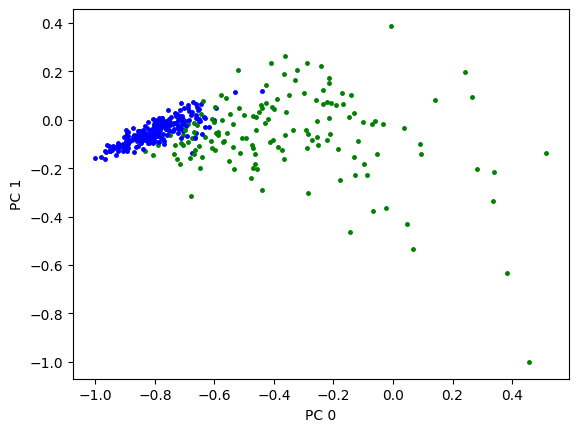

Blue: torch.Size([250])
Green: torch.Size([148])


In [15]:
# Plot dataset (only the first two args)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[1], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[1], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

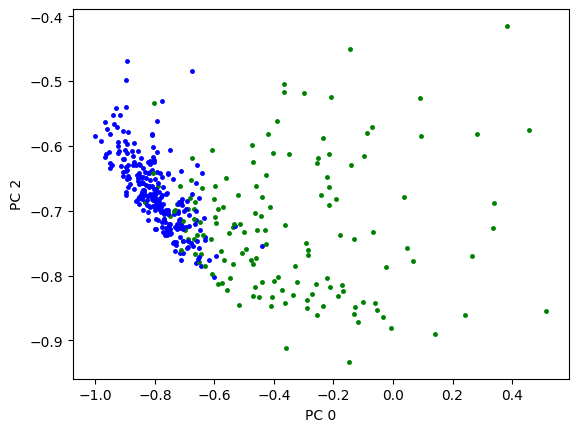

Blue: torch.Size([250])
Green: torch.Size([148])


In [16]:
# Plot dataset (only the first and the third arg)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[2], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[2], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 2')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

In [17]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(MAX_QUBITS_CLASSIFICATION, MAX_REPS, ENTANGLEMENT)
qc = circuitBuilder(feature_map, ansatz)

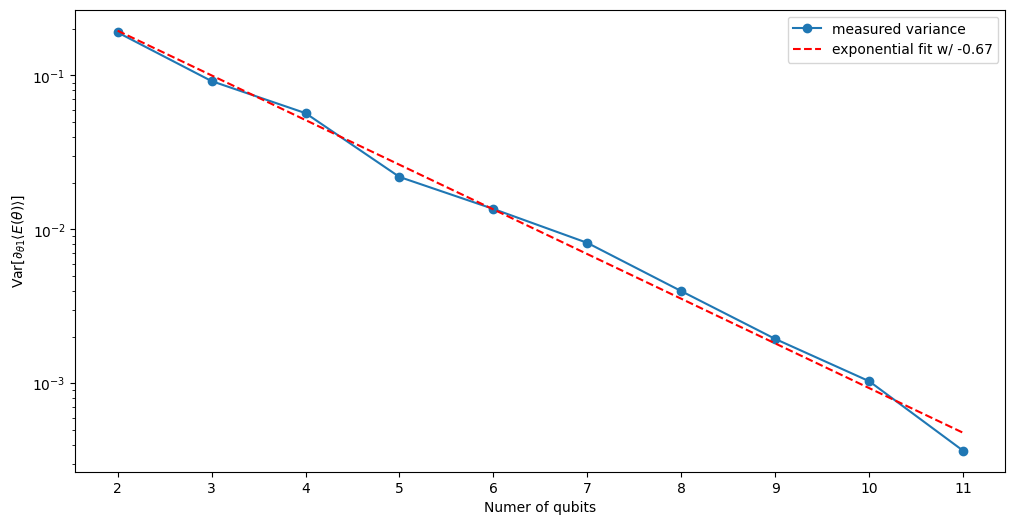

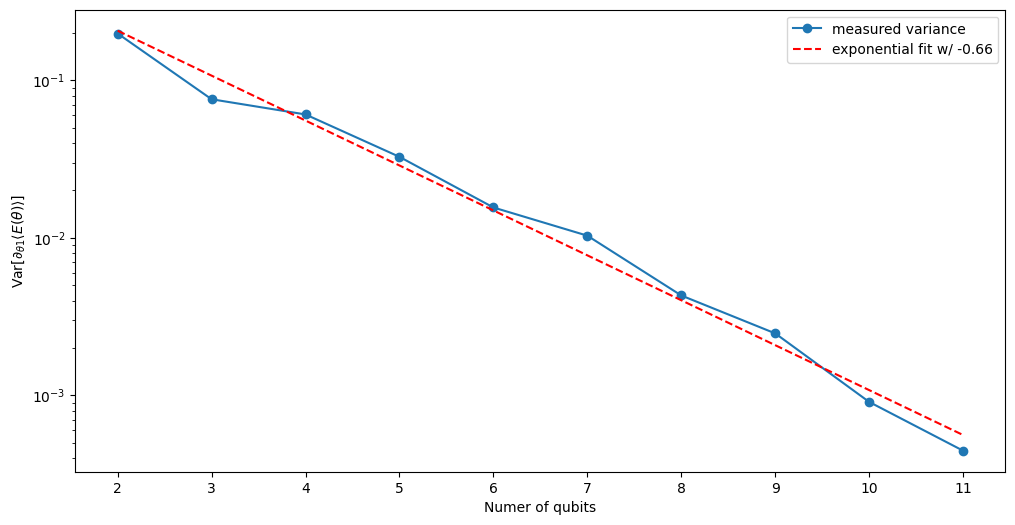

In [18]:
# To execute on multiple machines concurrently
# Select separate sub-lists of instance numbers and run
# Alternatively use range(MAX_INST) for all

m = METHOD_TAG
path = LOG_PATH
times = []

# for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: 
for i in [0, 1]: 
     
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}')):
        print(f'Adding a new instance {i} of method {m}\n')
    else:
        makedirs(f'{path}/{m}')
        print(f'Creating the first instance {i} of method {m}\n')

    m0_variances = sampleM0Var()
        
    # By default this will run as a local simulation
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=estimator,
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    # By default random initialisation
    model = TorchConnector(qnn)

    loss_function = nn.L1Loss() # nn.MSELoss()
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    start = time.time()
    model, losses, accuracy_train, accuracy_test, weights = train(
        model, 
        MAX_ITER, 
        X_train_t,
        y_train_t,
        X_val_t,
        y_val_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    elapsed = time.time() - start
    times.append(elapsed)

    pd.DataFrame(m0_variances, num_qubits).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Variances.csv')
    pd.DataFrame(losses).astype('float').to_csv(f'{path}/{m}/{m}-{i}-LossFunction.csv')
    pd.DataFrame(accuracy_train).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Train.csv')
    pd.DataFrame(accuracy_test).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Test.csv')
    pd.DataFrame(weights).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Weights.csv')
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}/{m}-Method.csv')):
        f = open(f'{path}/{m}/{m}-Method.csv', 'a')
    else:
        f = open(f'{path}/{m}/{m}-Method.csv', 'w')
        f.write(f'{m},Instance,Max Inst,Examples,Features,Iterations\n')
    f.write(f',{i},{MAX_INST},{DATA_SIZE},{FEATURE_DIM},{MAX_ITER}\n')
    f.close()
    
    clear_output(wait=True)


In [19]:
print(f'\nAverage time / instance: {np.average(times)}')


Average time / instance: 38927.07789051533


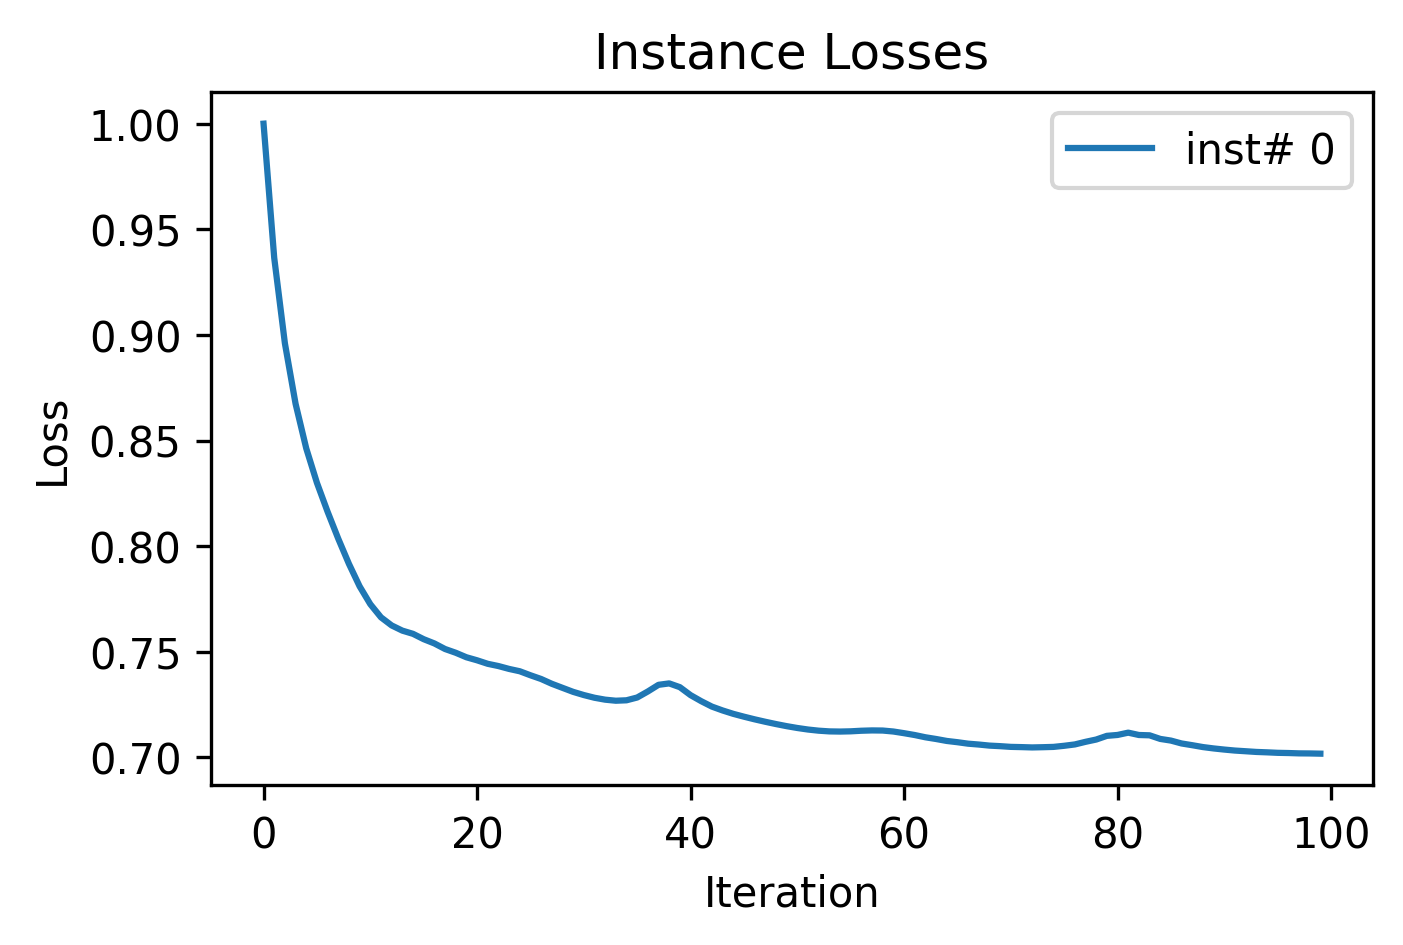

In [20]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(losses).astype('float').T])

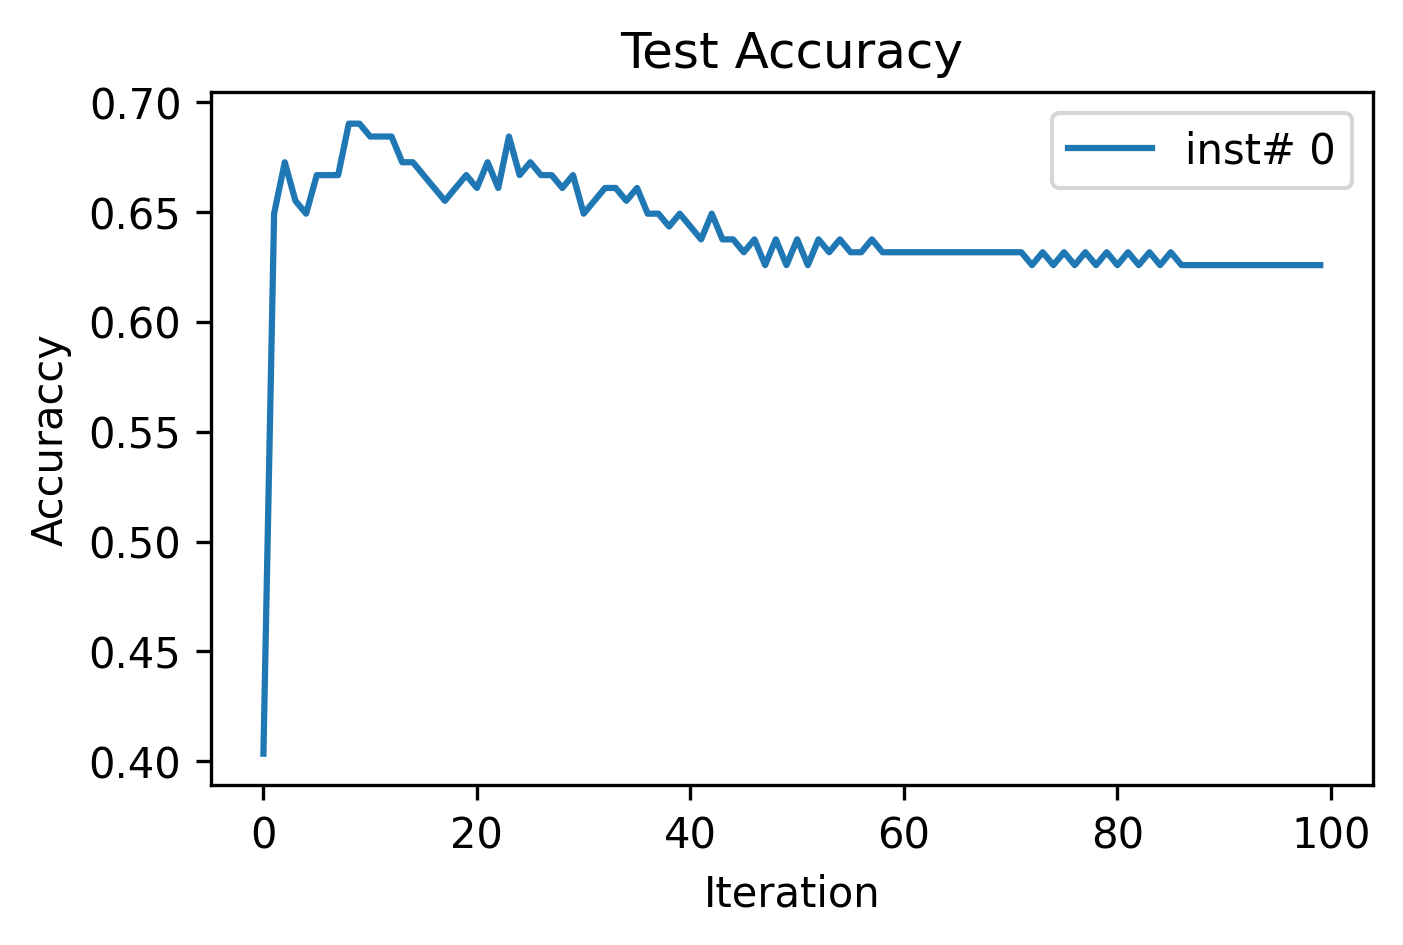

In [21]:
# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(accuracy_test).astype('float').T],
                title='Test Accuracy', dlabel='inst#', xlabel='Accuraccy', ylabel='Iteration')

In [22]:
!pip list | grep qiskit

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-finance                0.4.0
qiskit-ibm-provider           0.6.3
qiskit-ibm-runtime            0.11.3
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-qasm3-import           0.4.1
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.45.2


In [24]:
!pip list | grep torch

torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0
